In [684]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('fivethirtyeight')
sns.set(palette='pastel')
from datetime import datetime
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import warnings

warnings.filterwarnings("ignore")


In [685]:
train_set = pd.read_csv('Bases/train.csv')
train_set['Separation'] = "train"
test_set = pd.read_csv('Bases/test.csv')
test_set['Separation'] = "test"
df = train_set.append(test_set).set_index("PassengerId")
print(df.shape)
df.head(2)

(1309, 12)


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Separation
PassengerId,,,,,,,,,,,,
1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,train
2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,train


In [686]:
# Ticket - Pessoas na mesma Ca


# Feature Cleaning and engineering
---
Podemos começar o desenvolvimento utilizando as features que tenham todos os dados preenchidos e após isso seguimos das que faltam menos para as que faltam mais

Features sem nenhum dado faltante :  ['Pclass' 'Name' 'Sex' 'SibSp' 'Parch' 'Ticket' 'Separation']
Features com dados faltantes : 


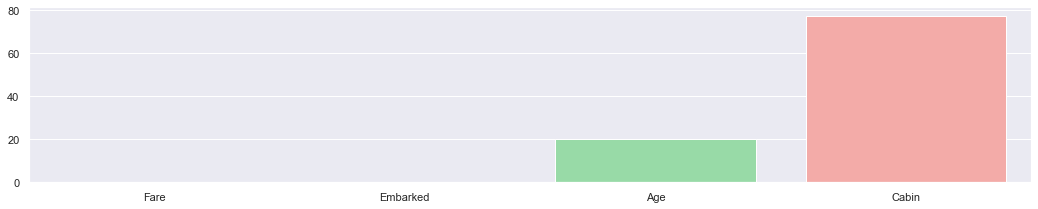

In [687]:
print("Features sem nenhum dado faltante : ",df.columns[df.isna().any() == False].values)
print("Features com dados faltantes : ",)
missing_features = (df.drop("Survived",axis=1).isna().sum().sort_values(ascending=True)/df.shape[0]*100).round(4)
missing_features = missing_features[missing_features > 0]
plt.figure(figsize=(16,3))
sns.barplot(x=missing_features.index,y=missing_features.values,estimator=sum)
plt.show()

In [688]:
# f, axs = plt.subplots(2,1,figsize=(15,4),sharex=True)
# train_missing_features = (train_set[train_set.columns[train_set.isna().any() == True]].isna().sum()/train_set.shape[0]).sort_values()
# sns.barplot(x=train_missing_features.index,y=train_missing_features.values,estimator=sum,ax=axs[0])
# test_missing_features = (test_set[test_set.columns[test_set.isna().any() == True]].isna().sum()/test_set.shape[0]).sort_values()
# sns.barplot(x=test_missing_features.index,y=test_missing_features.values,estimator=sum,ax=axs[1])

## Cabin
---

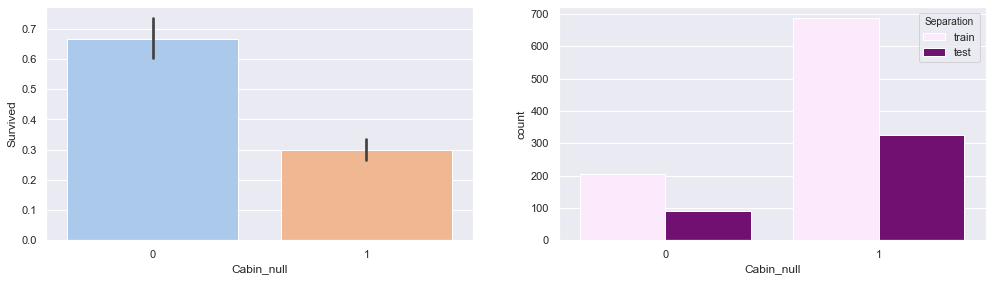

In [689]:
#df['Cabin_spaces']
df['Cabin_null'] = df['Cabin'].isna().astype(int)
f, axs = plt.subplots(1,2,figsize=(15,4))
sns.barplot(data=df,x='Cabin_null',y='Survived',ax=axs[0])
sns.countplot(data=df,x='Cabin_null',hue='Separation',ax=axs[1],color='purple')

In [690]:
#df[df.Ticket.duplicated(keep=False)].sort_values(['Pclass',"Ticket"]).iloc[30:40,:]

In [691]:
#df['Ticket_buy_order'] = df['Ticket'].apply(lambda x: int(str(x)[1:]))

In [692]:
#df.query("Ticket_isnumeric == False").sort_values("Ticket").iloc[60:90,:]

## Tickets
---
Como ideias para tickets a serem investigadas:
- Pode haver uma diferença entre os tickets numéricos e não numéricos
- a quantidade de caracteres pode indicar algo
- a quantidade de tickets iguais
- O inicio do ticket parece ser o numero da classe + os especiais
- Após o primeiro número ou parte não númerica, é a ordem em que foi adquirido o ticket


### Se é Numérico
---
Aparentemente não tem influência significativa entre as categorias

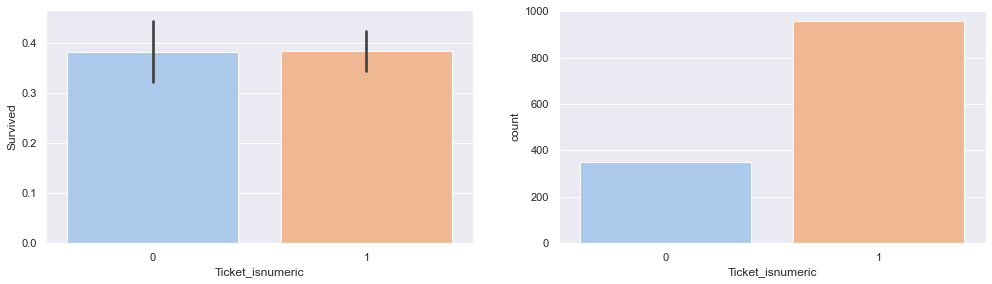

In [693]:
df['Ticket_isnumeric'] = (df['Ticket'].apply(lambda x: str(x)[0].isnumeric())).astype(int)
f, axs = plt.subplots(1,2,figsize=(15,4))
sns.barplot(data=df,x='Ticket_isnumeric',y='Survived',ax=axs[0])
sns.countplot(df['Ticket_isnumeric'],ax=axs[1])

plt.show()
df.drop(['Ticket_isnumeric'],axis=1,inplace=True)

### Primeiro caracter X Pclass
---
Não há diferença significativa entre as categorias

In [694]:
df['Ticket_firstchar'] = (df['Ticket'].apply(lambda x: str(x)[0]))
df.groupby(['Ticket_firstchar','Pclass']).agg({
    'Ticket':'count',
    'Survived':'mean'
})

Ticket  Survived
Ticket_firstchar Pclass                  
1                1          193  0.641221
                 2            3  0.000000
                 3           14  0.666667
2                1            8  1.000000
                 2          176  0.487395
                 3           94  0.383333
3                1           18  0.571429
                 2            5  0.600000
                 3          406  0.216312
4                3           11  0.200000
5                1            1  0.000000
                 3            2  0.000000
6                1            4  0.000000
                 3            5  0.250000
7                3           13  0.111111
8                3            2  0.000000
9                3            2  1.000000
A                3           42  0.068966
C                2           34  0.450000
                 3           43  0.259259
F                1            3  0.000000
                 2            9  0.800000
                 3            1  0.000000
L                3            5  0.250000
P                1           92  0.650000
                 2            2  0.500000
                 3            4  0.666667
S                2           43  0.407407
                 3           55  0.263158
W                1            4  0.333333
                 2            5  0.333333
                 3           10  0.000000

Aparentemente a maior parte dos tickets de cada classe começam com o número da classe, mas as médias não diferenciam tanto uma da outra

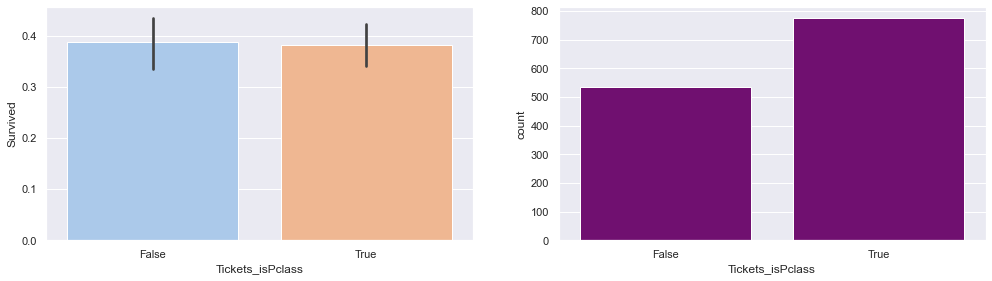

In [695]:
df['Tickets_isPclass'] = (df['Pclass'].astype(str) == df['Ticket_firstchar'])

f, axs = plt.subplots(1,2,figsize=(15,4))
sns.barplot(data=df,x='Tickets_isPclass',y='Survived',ax=axs[0])
sns.countplot(df['Tickets_isPclass'],ax=axs[1],color='purple')
plt.show()
df.drop(['Ticket_firstchar'],axis=1,inplace=True)

### Número de caracteres
---
Conseguimos chegar a uma feature mais interessante quando utilizamos a técnica de clusterização para reduzir a quantidade de valores possíveis, leva a evitar um possível overfit no modelo

In [696]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

In [697]:
class series_cluster:
    def __init__(self,series):
        self.data = series
    def mostra_grafico(self):
        inertias = self.calcular_inertias()
        plt.figure(figsize=(16,5))
        sns.lineplot(x=inertias[:,0],y=inertias[:,1])
    def retorna_clusters(self):
        cluster_array = self.data
        cluster_array['clusters'] = self.best_cluster_fit()
        series_name = cluster_array.columns[0]
        cluster_order = cluster_array.groupby('clusters')[series_name].mean().reset_index().sort_values(series_name,ascending=True).reset_index(drop=True).reset_index()
        cluster_order.set_index('clusters',inplace=True)
        cluster_array['clusters'] = cluster_array['clusters'].map(cluster_order['index'])
        return cluster_array['clusters']    
    def best_cluster_fit(self):
        inertias = self.calcular_inertias()
        melhor_n_cluster = self.n_otimo_clusters(inertias)
        kmeans = KMeans(n_clusters=melhor_n_cluster)
        kmeans.fit(self.data)
        return kmeans.labels_
    def calcular_inertias(self):
        inertias = []
        for cluster in range(2,15):
            kmeans = KMeans(n_clusters=cluster,random_state=7)
            kmeans.fit(self.data)
            inertias.append([cluster,kmeans.inertia_])
        inertias = np.array(inertias)
        return inertias
    def n_otimo_clusters(self,inertias):
        x_min,y_min = inertias[0,0],inertias[0,1] 
        x_max,y_max = inertias[-1,0],inertias[-1,1]
        distancia = []
        for i in range(0,len(inertias[:,0])):
            x,y = inertias[i,0], inertias[i,1]
            numerador = abs((y_max - y_min)*x - (x_max - x_min)*y + x_max*y_min - y_max*x_min)
            denominador = np.sqrt((y_max - y_min)**2 + (x_max - x_min)**2)
            distancia.append(numerador/denominador)
        distancia_df = {
            'clusters':inertias[:,0],
            'distancia':distancia
        }
        rank_clusters = pd.DataFrame(distancia_df)
        print('melhor cluster: ',int(rank_clusters.loc[rank_clusters['distancia'].idxmax(),'clusters']))
        #print(rank_clusters)
        return int(rank_clusters.loc[rank_clusters['distancia'].idxmax(),'clusters'])


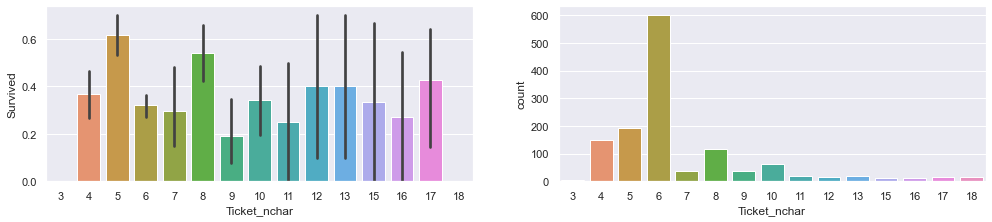

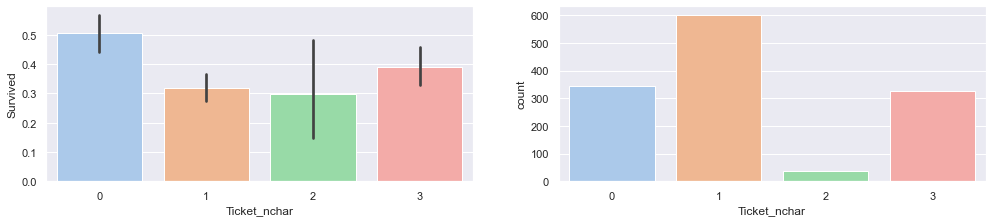

melhor cluster:  5


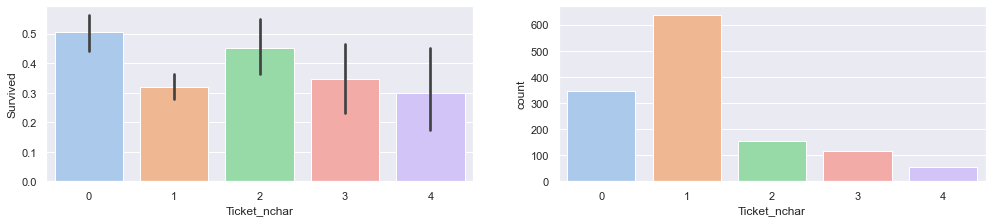

In [698]:
df['Ticket_nchar'] = (df['Ticket'].apply(lambda x: len(str(x))).astype(int))

f, axs = plt.subplots(1,2,figsize=(15,3))
sns.barplot(data=df,x='Ticket_nchar',y='Survived',ax=axs[0])
sns.countplot(data=df,x='Ticket_nchar',ax=axs[1])
plt.show()
df['Ticket_nchar'] = pd.qcut(df['Ticket_nchar'],4,labels=np.arange(0,4))
f, axs = plt.subplots(1,2,figsize=(15,3))
sns.barplot(data=df,x='Ticket_nchar',y='Survived',ax=axs[0])
sns.countplot(data=df,x='Ticket_nchar',ax=axs[1])
plt.show()


df['Ticket_nchar'] = (df['Ticket'].apply(lambda x: len(str(x))).astype(int))
clusters_series_model = series_cluster(df[['Ticket_nchar']])
df['Ticket_nchar'] = clusters_series_model.retorna_clusters()
f, axs = plt.subplots(1,2,figsize=(15,3))
sns.barplot(data=df,x='Ticket_nchar',y='Survived',ax=axs[0])
sns.countplot(data=df,x='Ticket_nchar',ax=axs[1])
plt.show()

df['Ticket_nchar'] = (df['Ticket'].apply(lambda x: len(str(x))).astype(int))

### Quantidade de Tickets
---
Uma feature que tem diferenças notável entre as categorias, pode ser bem aplicada

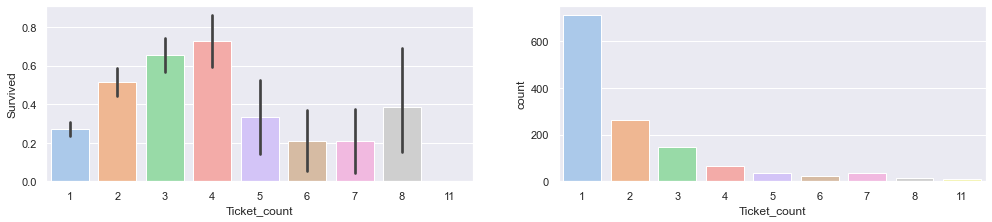

melhor cluster:  5


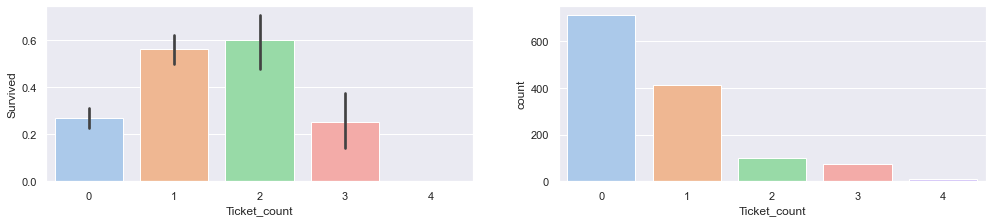

In [699]:
f, axs = plt.subplots(1,2,figsize=(15,3))
df['Ticket_count'] = df.Ticket.map(df.Ticket.value_counts())
sns.barplot(data=df,x='Ticket_count',y='Survived',ax=axs[0])
sns.countplot(df['Ticket_count'],ax=axs[1])
plt.show()


df['Ticket_count'] = series_cluster(df[['Ticket_count']]).retorna_clusters()
f, axs = plt.subplots(1,2,figsize=(15,3))
sns.barplot(data=df,x='Ticket_count',y='Survived',ax=axs[0])
sns.countplot(df['Ticket_count'],ax=axs[1])
plt.show()
df['Ticket_count'] = df.Ticket.map(df.Ticket.value_counts())

### Ordem de compra
--- 

In [700]:
df.Ticket.sample(20)

PassengerId
685               29750
65             PC 17605
349          C.A. 37671
1020             211535
380              347069
930              345768
861              350026
689              350036
765              347074
584               13049
918              113509
221     SOTON/OQ 392089
869              345777
816              112058
607              349246
242              367230
603              113796
1004           PC 17531
36               113789
862               28134
Name: Ticket, dtype: object

In [701]:
# #df[df.Ticket.duplicated(keep=False)].sort_values(['Pclass',"Ticket"]).iloc[30:60,:]
# f, axs = plt.subplots(2,2,figsize=(15,10))
# df['Ticket_count'] = df.Ticket.map(df.Ticket.value_counts())
# df['Ticket_isnumeric'] = (df['Ticket'].apply(lambda x: str(x)[0].isnumeric())).astype(int)
# df['Ticket_firstchar'] = (df['Ticket'].apply(lambda x: str(x)[0]))
# df['Ticket_nchar'] = (df['Ticket'].apply(lambda x: len(x)).astype(int))
# sns.barplot(data=df,x='Ticket_count',y='Survived',ax=axs[0,1])
# sns.countplot(df['Ticket_count'],ax=axs[0,0])
# sns.barplot(data=df,x='Ticket_isnumeric',y='Survived',ax=axs[1,1])
# sns.countplot(df['Ticket_isnumeric'],ax=axs[1,0])
# plt.show()

## Names
---
Ideias atuais:
- Verificar o pronome de tratamento
- Alguns nomes tem um (), pode ser que isso seja algo importante
- Podemos verificar quantas vezes o sobrenome se repete, pode trazer alguma informação importante de proximidade ou parentesco

### Pronome de tratamento
---

In [702]:
df['name_treatment'] = df['Name'].str.split(", ",expand=True).loc[:,1].str.split(" ",expand=True).loc[:,0]
df.head(2)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Separation,Cabin_null,Tickets_isPclass,Ticket_nchar,Ticket_count,name_treatment
PassengerId,,,,,,,,,,,,,,,,,
1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,train,1,False,9,1,Mr.
2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,train,0,False,8,2,Mrs.


In [703]:
df[df['Name'].str.contains('Harper')]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Separation,Cabin_null,Tickets_isPclass,Ticket_nchar,Ticket_count,name_treatment
PassengerId,,,,,,,,,,,,,,,,,
53,1.0,1,"Harper, Mrs. Henry Sleeper (Myna Haxtun)",female,49.0,1,0,PC 17572,76.7292,D33,C,train,0,False,8,3,Mrs.
646,1.0,1,"Harper, Mr. Henry Sleeper",male,48.0,1,0,PC 17572,76.7292,D33,C,train,0,False,8,3,Mr.
721,1.0,2,"Harper, Miss. Annie Jessie ""Nina""",female,6.0,0,1,248727,33.0000,NaN,S,train,1,True,6,3,Miss.
849,0.0,2,"Harper, Rev. John",male,28.0,0,1,248727,33.0000,NaN,S,train,1,True,6,3,Rev.


In [704]:
df.loc[((df['name_treatment'].str.contains("Dr.")) & (df['Sex'] == "male")),"name_treatment"] = "Mr."
df.loc[((df['name_treatment'].str.contains("Dr.")) & (df['Sex'] != "male")),"name_treatment"] = "Miss."

In [705]:
df['name_treatment'].replace(['the', 'Lady.','Mme.','Mlle.','Dona.','Mrs.'],'Mrs.',inplace=True) # Ladies
df['name_treatment'].replace(['Ms.','Miss.'],'Miss.',inplace=True) # Ladies
df['name_treatment'].replace(['Jonkheer.','Don.','Capt.','Don.','Sir.','Col.','Major.'],"Mr.",inplace=True)
#df['name_treatment'].value_counts()

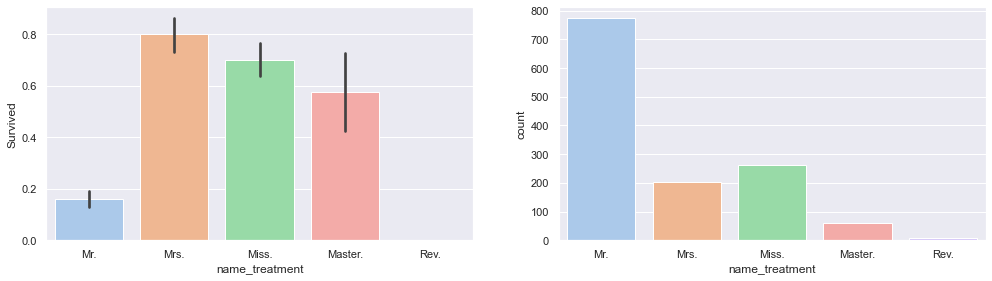

In [706]:
f, axs = plt.subplots(1,2,figsize=(15,4))
sns.barplot(data=df,x='name_treatment',y='Survived',ax=axs[0])
sns.countplot(df['name_treatment'],ax=axs[1])

### Verificar ()
--- 
Uma feature com muita diferença e que pode trazer bastante resultado, já que ao menos 100 pessoas em cada categorias e elas são bem divergentes

In [707]:
df['Name_has()'] = df['Name'].apply(lambda x: "(" in x)

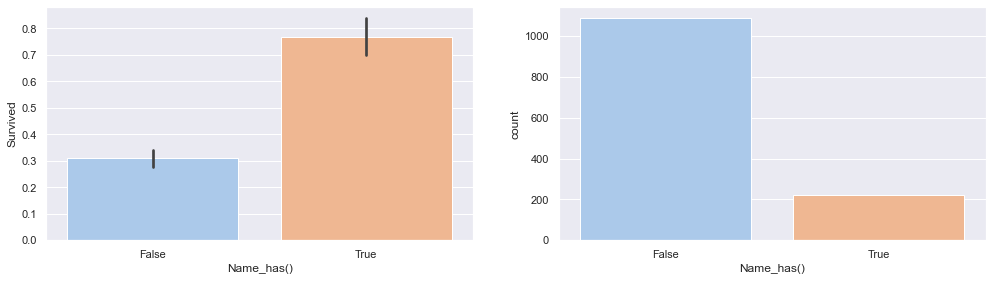

In [708]:
f, axs = plt.subplots(1,2,figsize=(15,4))
sns.barplot(data=df,x='Name_has()',y='Survived',ax=axs[0])
sns.countplot(df['Name_has()'],ax=axs[1])

### Sobrenome
--- 


## SibSP e Parch
---
Ideias
- Tentar montar a familia completa
- Se está sozinho
- Tentar ver a distribuição por clusters

### Familia Completa
--- 


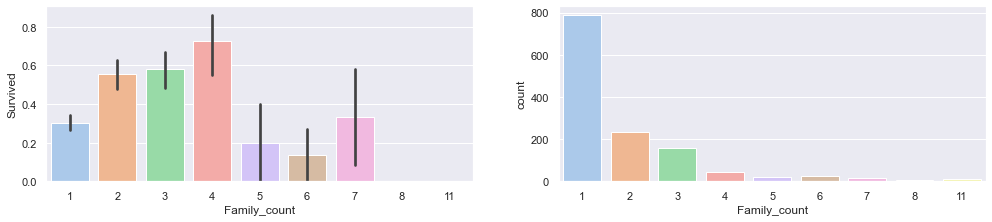

melhor cluster:  5


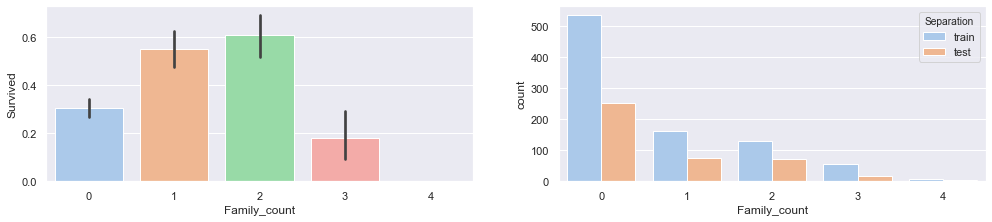

In [709]:
df['Family_count'] = df['Parch'] + df['SibSp'] + 1
f, axs = plt.subplots(1,2,figsize=(15,3))
sns.barplot(data=df,x='Family_count',y='Survived',ax=axs[0])
sns.countplot(df['Family_count'],ax=axs[1])
plt.show()

df['Family_count'] = series_cluster(df[['Family_count']]).retorna_clusters()
f, axs = plt.subplots(1,2,figsize=(15,3))
sns.barplot(data=df,x='Family_count',y='Survived',ax=axs[0])
sns.countplot(data=df, x='Family_count',hue='Separation',ax=axs[1])
plt.show()
df['Family_count'] = df['Parch'] + df['SibSp'] + 1

### Se está sozinho
--- 

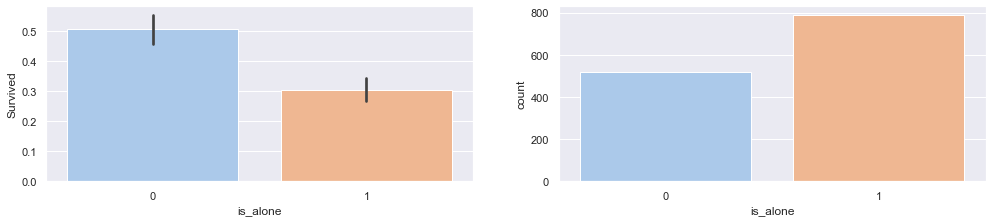

In [710]:
df['is_alone'] = (df['Family_count'] == 1).astype(int)
f, axs = plt.subplots(1,2,figsize=(15,3))
sns.barplot(data=df,x='is_alone',y='Survived',ax=axs[0])
sns.countplot(df['is_alone'],ax=axs[1])
plt.show()

### Distribuição por Clusters
---

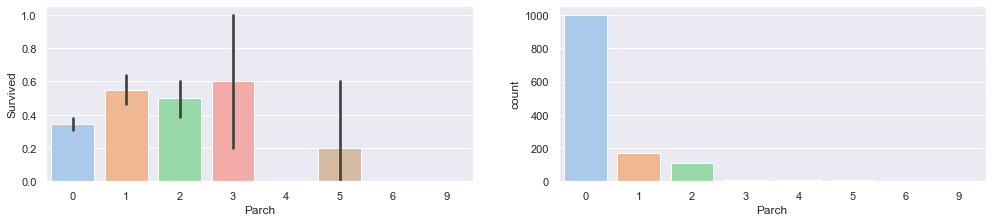

melhor cluster:  5


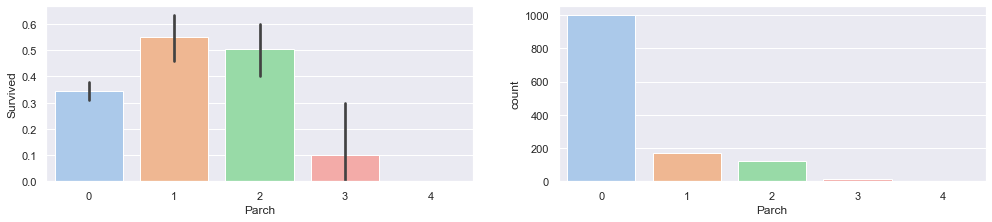

In [711]:
# df['Fare'] = series_cluster(df[['Fare']]).retorna_clusters()
f, axs = plt.subplots(1,2,figsize=(15,3))
sns.barplot(data=df,x='Parch',y='Survived',ax=axs[0])
sns.countplot(df['Parch'],ax=axs[1])
plt.show()

df['Parch'] = series_cluster(df[['Parch']]).retorna_clusters()
f, axs = plt.subplots(1,2,figsize=(15,3))
sns.barplot(data=df,x='Parch',y='Survived',ax=axs[0])
sns.countplot(df['Parch'],ax=axs[1])
plt.show()

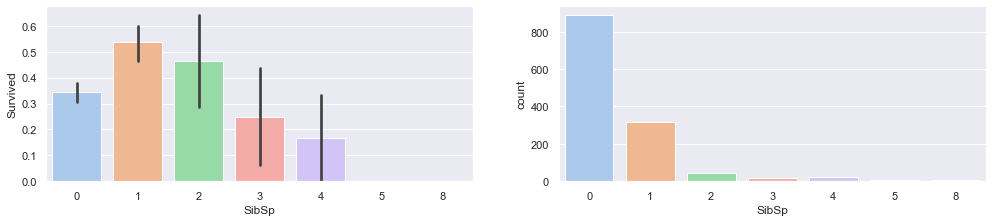

melhor cluster:  4


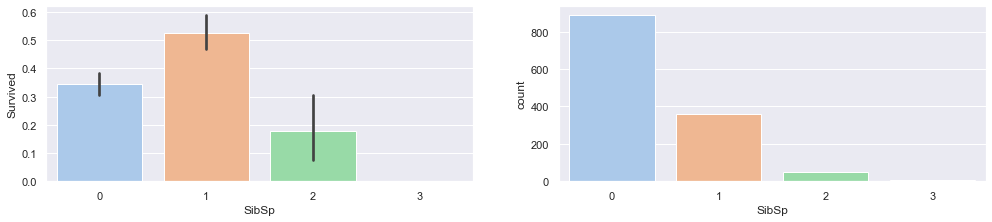

In [712]:
f, axs = plt.subplots(1,2,figsize=(15,3))
sns.barplot(data=df,x='SibSp',y='Survived',ax=axs[0])
sns.countplot(df['SibSp'],ax=axs[1])
plt.show()

df['SibSp'] = series_cluster(df[['SibSp']]).retorna_clusters()
f, axs = plt.subplots(1,2,figsize=(15,3))
sns.barplot(data=df,x='SibSp',y='Survived',ax=axs[0])
sns.countplot(df['SibSp'],ax=axs[1])
plt.show()

## Fare
---
- Utilizando a Fare média da Pclass dessa pessoa
- Fazer um Fare por Ticket e por Tamanho da Familia parecem ser escolhas interessantes

### Tratamento Com Fare média
---

In [713]:
df.loc[df['Fare'].isna(),"Fare"] = 13.35
#df.groupby(['Pclass','Cabin'],as_index=False).Fare.mean()

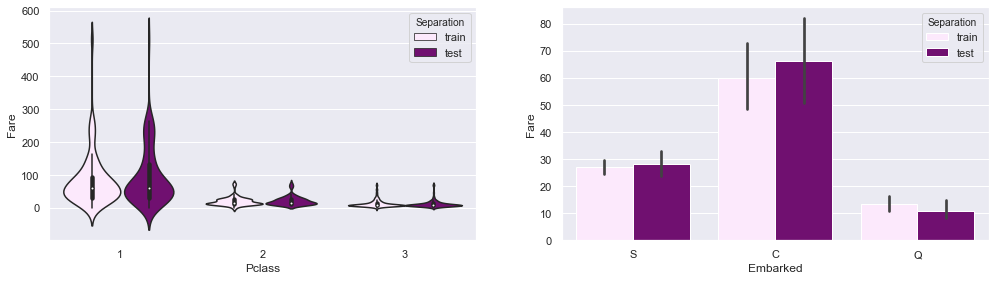

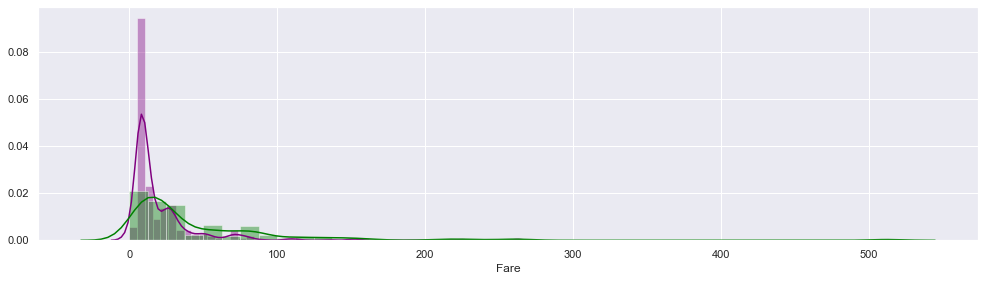

In [714]:
f, axs = plt.subplots(1,2,figsize=(15,4))
df.loc[df['Fare'].isna(),"Fare"] = 13.35
sns.violinplot(data=df,y='Fare',x='Pclass',hue='Separation',ax=axs[0],color='purple')
sns.barplot(data=df,y='Fare',x='Embarked',hue='Separation',ax=axs[1],color='purple')
plt.show()
plt.figure(figsize=(15,4))
sns.distplot(df.query("Survived == 0")['Fare'],color='purple')
sns.distplot(df.query("Survived == 1")['Fare'],color='green')
plt.show()

# df['Fare'] = series_cluster(df[['Fare']]).retorna_clusters()
# f, axs = plt.subplots(1,2,figsize=(15,3))
# sns.barplot(data=df,x='Fare',y='Survived',ax=axs[0])
# sns.countplot(df['Fare'],ax=axs[1])
# plt.show()

### Fare Por Ticket
--- 

melhor cluster:  4


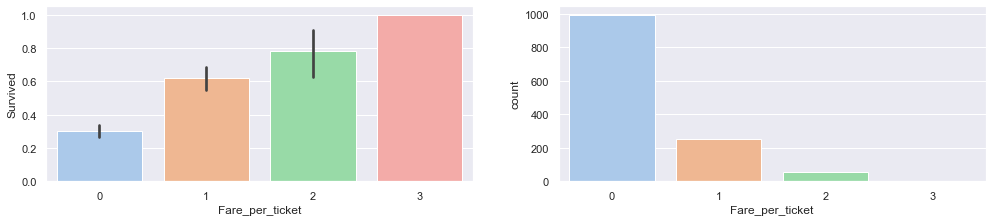

In [715]:
df['Fare_per_ticket'] = df['Fare']/(df['Ticket_count']+1)

def create_commom_graph(col):
    f, axs = plt.subplots(1,2,figsize=(15,3))
    sns.barplot(data=df,x=col,y='Survived',ax=axs[0])
    sns.countplot(df[col],ax=axs[1])
    plt.show()
    
#create_commom_graph('Fare_per_ticket')
df['Fare_per_ticket'] = series_cluster(df[['Fare_per_ticket']]).retorna_clusters()
create_commom_graph('Fare_per_ticket')

### Fare per Family
--- 



melhor cluster:  5


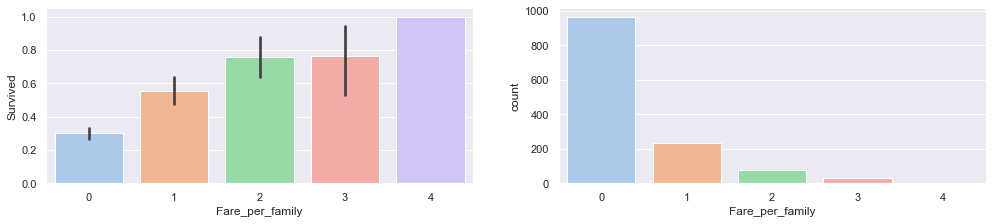

In [716]:
#create_commom_graph('Fare_per_ticket')
df['Fare_per_family'] = df['Fare']/(df['Family_count']+1)
df['Fare_per_family'] = series_cluster(df[['Fare_per_family']]).retorna_clusters()
create_commom_graph('Fare_per_family')

## Embarked
--- 


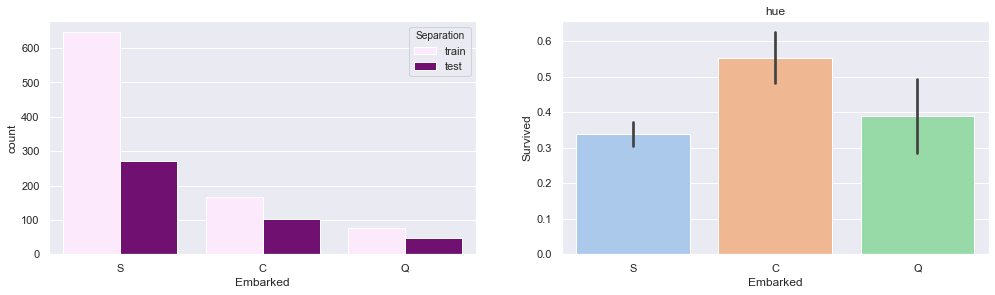

In [717]:
f, axs = plt.subplots(1,2,figsize=(15,4))
df['Embarked'] = df['Embarked'].fillna("S")
sns.countplot(data=df,x='Embarked',hue='Separation',ax=axs[0],color='purple')
axs[1].set_title("hue")
sns.barplot(data=df,y='Survived',x='Embarked',ax=axs[1])

## Age
---

In [718]:

df.drop(['Ticket','Name','Cabin','Separation'],axis=1,inplace=True)
#df.drop(['Ticket','Name','Cabin','Separation'],axis=1).dtypes

In [719]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score

In [720]:
age_df = df.drop(['Survived'],axis=1) #[["name_treatment",'Embarked','Sex','Fare','Age','Pclass']]

In [721]:
#age_df.dtypes

In [722]:
from sklearn.preprocessing import LabelEncoder,One
label_encoder = LabelEncoder()
to_labeling = ["name_treatment",'Embarked','Sex']
age_df[to_labeling] = age_df[to_labeling].apply(label_encoder.fit_transform)
age_df.head(2)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Cabin_null,Tickets_isPclass,Ticket_nchar,Ticket_count,name_treatment,Name_has(),Family_count,is_alone,Fare_per_ticket,Fare_per_family
PassengerId,,,,,,,,,,,,,,,,,
1,3,1,22.0,1,0,7.2500,2,1,False,9,1,2,False,2,0,0,0
2,1,0,38.0,1,0,71.2833,0,0,False,8,2,3,True,2,0,1,1


In [723]:
age_train = age_df[age_df["Age"].isna() == False]
age_test = age_df[age_df["Age"].isna()]

In [724]:
from sklearn.model_selection import RepeatedStratifiedKFold
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)

In [725]:
age_model = RandomForestRegressor(n_estimators=10,random_state=7)
age_model.fit(age_train.drop(['Age'],axis=1), age_train['Age'])
r2_score(age_train['Age'],age_model.predict(age_train.drop(['Age'],axis=1)))

0.7800582437303584

In [726]:
#n_scores = cross_val_score(age_model, age_train.drop(['Age'],axis=1), age_train['Age'], cv=cv, n_jobs=-1, error_score='raise')
#print('R2: %.3f +- (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

In [727]:
age_test['Age'] = age_model.predict(age_test.drop(['Age'],axis=1))
df['Age'] = age_train.append(age_test).sort_index()['Age']

# Overfit avoiding
---

In [728]:
df['Ticket_nchar'] = series_cluster(df[['Ticket_nchar']]).retorna_clusters()
df['Ticket_count'] = series_cluster(df[['Ticket_count']]).retorna_clusters()
df['Fare'] = series_cluster(df[['Fare']]).retorna_clusters()
df['Age'] = series_cluster(df[['Age']]).retorna_clusters()

melhor cluster:  5
melhor cluster:  5
melhor cluster:  5
melhor cluster:  5


# Preprocessamento
--- 

In [729]:
df['Sex'] = df['Sex'].map({
    'male':0,
    'female':1
})

In [869]:
#df_dummies = pd.get_dummies(df[['Age','name_treatment','Family_count','Fare','Pclass','Embarked']],columns=['Embarked','name_treatment'],drop_first=True)
df_dummies = pd.get_dummies(df,columns=['Embarked','name_treatment'],drop_first=True)

In [883]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

data = pd.DataFrame(scaler.fit_transform(df_dummies),index=df_dummies.index,columns=df_dummies.columns)
pca = PCA(n_components=7)
data = pd.DataFrame(pca.fit_transform(data),index=data.index)
data['Survived'] = df['Survived']
data.head(2)

,0,1,2,3,4,5,6,Survived
PassengerId,,,,,,,,
1,-1.343131,-1.233667,1.539845,-0.299503,0.9726,0.491125,-0.169509,0.0
2,4.356782,1.572750,-1.276739,-1.959517,0.6644,1.767087,0.144607,1.0


In [871]:
data_train = data.loc[train_set['PassengerId'].values,:].copy()
data_test = data.loc[test_set['PassengerId'].values,:].copy()
feature_cols = data_train.columns.drop('Survived')

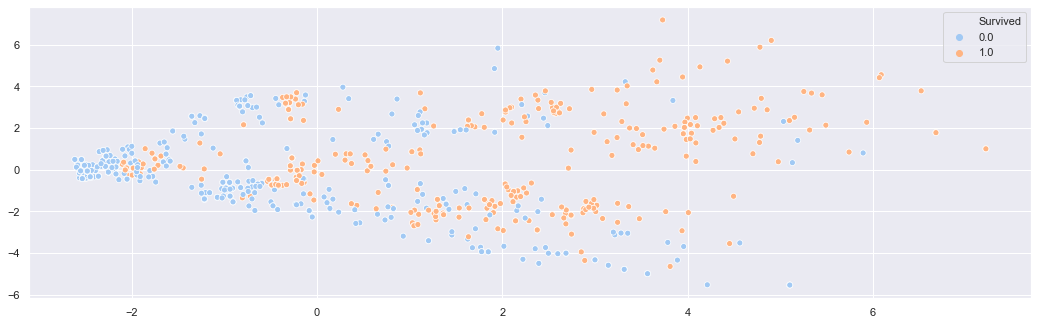

In [872]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
df_visual = pca.fit_transform(data_train[feature_cols])
plt.figure(figsize=(16,5))
sns.scatterplot(x=df_visual[:,0],y=df_visual[:,1],hue=data_train['Survived'])

# Modelo
---
- Start 82.9%  SVC
- Adicionado Ticket_count, ticket_char_count e se tem () no nome, todos esses + Fare foram reescalados usando o kmeans 82,8% SVC
- Não usando clusters no Fare 83.4% SVC
- [83.4% SVC] Retirando o Ticket_isnumeric
- [84% LightGBM] Não escalando a quantidade de tickets (75% no teste)

## LogisticRegression
--- 

In [878]:
from sklearn.linear_model import LogisticRegressionCV
model = LogisticRegressionCV(random_state=7)

tuning_params = {
    'max_iter': [300,200,100,5,10,30],
    'penalty':['l2','l1'],
    'solver':['liblinear'],
    'tol':[0.0001,0.001,0.01,0.1,1]
}

grid_model = GridSearchCV(model,param_grid=tuning_params,scoring='accuracy',n_jobs=-1,cv=cv,return_train_score=True)
grid_model.fit(data_train[feature_cols], data_train['Survived'])
print("Fitado!")
print("melhores parametros: ",grid_model.best_params_)
print("melhor score: ",grid_model.best_score_)
best_model = grid_model.best_estimator_
n_scores = cross_val_score(best_model, data_train[feature_cols], data_train['Survived'], scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy: %.3f +- (%.3f)' % (np.mean(n_scores), np.std(n_scores)))
pd.DataFrame(grid_model.cv_results_).sort_values('rank_test_score').head(3)[['mean_train_score','mean_test_score']]

Fitado!
melhores parametros:  {'max_iter': 300, 'penalty': 'l2', 'solver': 'liblinear', 'tol': 0.0001}
melhor score:  0.9001122334455668
Accuracy: 0.900 +- (0.021)


,mean_train_score,mean_test_score
0,0.898431,0.900112
21,0.898431,0.900112
22,0.898431,0.900112


## LightGBM
--- 

In [846]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
model = LGBMClassifier(random_state=7)

tuning_params = {
    'num_leaves': [2,3,4,8,16],
    'n_estimators':[50,100,200,300,500],
    'max_depth':[-1,2,4,8],
    'learning_rate':[0.01,0.1],
    'reg_lambda':[0.7,1,1.5,2,4,7]
}

grid_model = GridSearchCV(model,param_grid=tuning_params,scoring='accuracy',n_jobs=-1,cv=cv,return_train_score=True)
grid_model.fit(data_train[feature_cols], data_train['Survived'])
print("Fitado!")
print("melhores parametros: ",grid_model.best_params_)
print("melhor score: ",grid_model.best_score_)
best_model = grid_model.best_estimator_
n_scores = cross_val_score(best_model, data_train[feature_cols], data_train['Survived'], scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy: %.3f +- (%.3f)' % (np.mean(n_scores), np.std(n_scores)))
pd.DataFrame(grid_model.cv_results_).sort_values('rank_test_score').head(3)[['mean_train_score','mean_test_score']]

Fitado!
melhores parametros:  {'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 300, 'num_leaves': 4, 'reg_lambda': 0.7}
melhor score:  0.9640852974186308
Accuracy: 0.964 +- (0.016)


,mean_train_score,mean_test_score
1002,1.0,0.964085
702,1.0,0.964085
1152,1.0,0.964085


## SVC
--- 

In [852]:
from sklearn.svm import SVC

model = SVC(random_state=7)

tuning_params = {
    'C': [0.1,0.5,1,2,3,5,7,10,20],
    'kernel':['rbf','poly','sigmoid'],
    'degree':[1,2,3,4]
}
grid_model = GridSearchCV(model,param_grid=tuning_params,scoring='accuracy',n_jobs=-1,cv=cv,return_train_score=True)
grid_model.fit(data_train[feature_cols], data_train['Survived'])
print("Fitado!")
print("melhores parametros: ",grid_model.best_params_)
print("melhor score: ",grid_model.best_score_)
best_model = grid_model.best_estimator_
n_scores = cross_val_score(best_model, data_train[feature_cols], data_train['Survived'], scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy: %.3f +- (%.3f)' % (np.mean(n_scores), np.std(n_scores)))
pd.DataFrame(grid_model.cv_results_).sort_values('rank_test_score').head(3)[['mean_train_score','mean_test_score']]

Fitado!
melhores parametros:  {'C': 5, 'degree': 1, 'kernel': 'rbf'}
melhor score:  0.9753086419753086
Accuracy: 0.975 +- (0.012)


,mean_train_score,mean_test_score
69,0.998036,0.975309
66,0.998036,0.975309
63,0.998036,0.975309


## KNN
---

In [848]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier()

tuning_params = {
    'n_neighbors': [2,3,5,8,11,17,23],
    'weights':['uniform','distance']
}
grid_model = GridSearchCV(model,param_grid=tuning_params,scoring='accuracy',n_jobs=-1,cv=cv,return_train_score=True)
grid_model.fit(data_train[feature_cols], data_train['Survived'])
print("Fitado!")
print("melhores parametros: ",grid_model.best_params_)
print("melhor score: ",grid_model.best_score_)
best_model = grid_model.best_estimator_
n_scores = cross_val_score(best_model, data_train[feature_cols], data_train['Survived'], scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy: %.3f +- (%.3f)' % (np.mean(n_scores), np.std(n_scores)))
pd.DataFrame(grid_model.cv_results_).sort_values('rank_test_score').head(3)[['mean_train_score','mean_test_score']]

Fitado!
melhores parametros:  {'n_neighbors': 3, 'weights': 'distance'}
melhor score:  0.9349046015712682
Accuracy: 0.935 +- (0.015)


,mean_train_score,mean_test_score
3,1.0,0.934905
7,1.0,0.934905
9,1.0,0.934905


# Prediction
---

In [879]:
data_test['Survived'] = best_model.predict(data_test[feature_cols])
data_test['Survived'] = data_test['Survived'].astype(int)
data_test['Survived'].value_counts(normalize=True)

0    0.602871
1    0.397129
Name: Survived, dtype: float64

In [880]:
df.loc[data_test.index,'Survived'] = data_test['Survived']
df_test = df.loc[data_test.index,:]
df_train = df.loc[data_train.index,:]
df_test.head(2)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Cabin_null,Tickets_isPclass,Ticket_nchar,Ticket_count,name_treatment,Name_has(),Family_count,is_alone,Fare_per_ticket,Fare_per_family
PassengerId,,,,,,,,,,,,,,,,,,
892,0.0,3,0,2,0,0,0,Q,1,True,1,0,Mr.,False,1,1,0,0
893,0.0,3,1,3,1,0,0,S,1,True,1,0,Mrs.,True,2,0,0,0


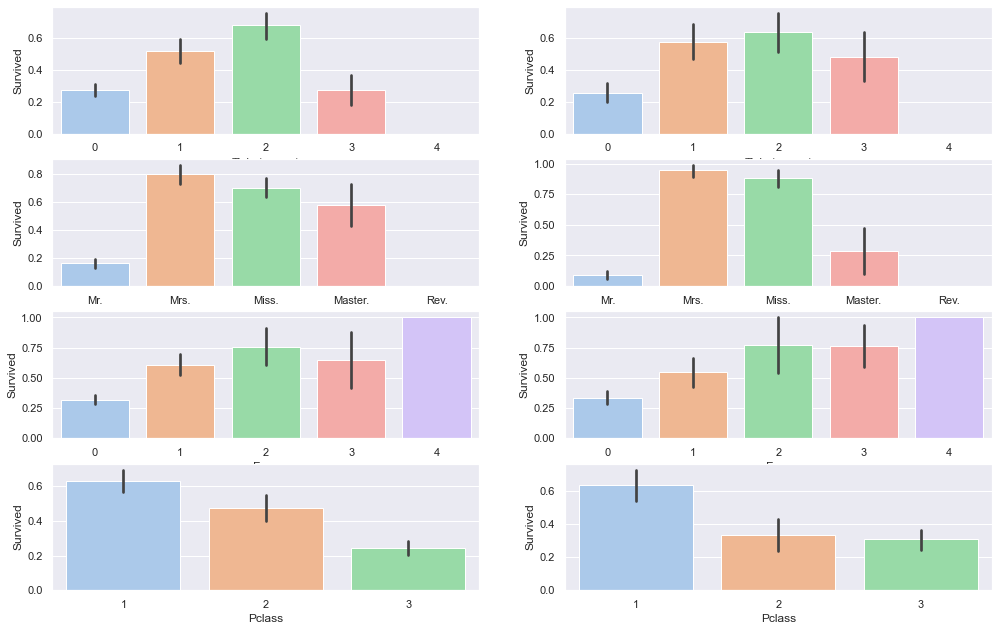

In [881]:
f, axs = plt.subplots(4,2,figsize=(15,10))
sns.barplot(data=df_train,x='Ticket_count',y='Survived',ax=axs[0,0])
sns.barplot(data=df_test,x='Ticket_count',y='Survived',ax=axs[0,1])
sns.barplot(data=df_train,x='name_treatment',y='Survived',ax=axs[1,0])
sns.barplot(data=df_test,x='name_treatment',y='Survived',ax=axs[1,1])
sns.barplot(data=df_train,x='Fare',y='Survived',ax=axs[2,0])
sns.barplot(data=df_test,x='Fare',y='Survived',ax=axs[2,1])
sns.barplot(data=df_train,x='Pclass',y='Survived',ax=axs[3,0])
sns.barplot(data=df_test,x='Pclass',y='Survived',ax=axs[3,1])
plt.show()

In [863]:
test_set.set_index("PassengerId").loc[df_test.query("name_treatment == 'Mr.' & Survived == 1").index,:]

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Separation
PassengerId,,,,,,,,,,,
915,1,"Williams, Mr. Richard Norris II",male,21.0,0,1,PC 17597,61.3792,NaN,C,test
926,1,"Mock, Mr. Philipp Edmund",male,30.0,1,0,13236,57.7500,C78,C,test
927,3,"Katavelas, Mr. Vassilios (Catavelas Vassilios"")""",male,18.5,0,0,2682,7.2292,NaN,C,test
931,3,"Hee, Mr. Ling",male,NaN,0,0,1601,56.4958,NaN,S,test
960,1,"Tucker, Mr. Gilbert Milligan Jr",male,31.0,0,0,2543,28.5375,C53,C,test
965,1,"Ovies y Rodriguez, Mr. Servando",male,28.5,0,0,PC 17562,27.7208,D43,C,test
1036,1,"Lindeberg-Lind, Mr. Erik Gustaf (Mr Edward Lin...",male,42.0,0,0,17475,26.5500,NaN,S,test
1069,1,"Stengel, Mr. Charles Emil Henry",male,54.0,1,0,11778,55.4417,C116,C,test
1073,1,"Compton, Mr. Alexander Taylor Jr",male,37.0,1,1,PC 17756,83.1583,E52,C,test


In [882]:
data_test[['Survived']].reset_index().to_csv("Submissions/" + str(datetime.today().date()) + " LogisticRegression.csv",index=False)

In [302]:
data_train['Survived'].value_counts(normalize=True)

0.0    0.616162
1.0    0.383838
Name: Survived, dtype: float64